## Fixed Income Examples

 0. **Setup**
 
 1. **Market data generation**
    1. Rolling series of government bonds
    2. Corporate bonds with spreads driven by a common factor
 
 
 2. **Example 1: Basic Strategies**
    1. Weigh all active corporate bond equally
    2. Add hedging of interest rates risk with the on-the-run government bond
 
 
 3. **Example 2: Nested Strategies**
    1. One strategy buys the top N bonds, by yield
    2. Another strategy sells the bottom N bonds, by yield
    3. Parent strategy gives 50% weight to each of the above
    4. Add hedges of remaining interest rates risk with the on-the-run government bond

In [1]:
# add quantkit to path
import sys
from pathlib import Path

d = Path().resolve().parent.parent
sys.path.insert(0, str(d))

### Setup

In [2]:
import quantkit.bt as bt
import quantkit.bt.frequency as frequency
import quantkit.bt.signals as signals
import quantkit.bt.portfolio_management as portfolio_management
import quantkit.bt.risk_management as risk_management
import quantkit.bt.weighting_schemes as weighting_schemes
import quantkit.bt.technical_analysis as technical_analysis
import quantkit.bt.util as util

import pandas as pd
from pandas.tseries.frequencies import to_offset
from pandas.tseries.offsets import BDay
import numpy as np

import warnings

warnings.filterwarnings("ignore")

np.random.seed(1234)
%matplotlib inline

pd.set_option("display.max_rows", 10)

In [3]:
# (Approximate) Price to yield calcs, and pvbp, for later use. Note we use clean price here.
def price_to_yield(p, ttm, coupon):
    return (coupon + (100.0 - p) / ttm) / ((100.0 + p) / 2.0) * 100


def yield_to_price(y, ttm, coupon):
    return (coupon + 100 / ttm - 0.5 * y) / (y / 200 + 1 / ttm)


def pvbp(y, ttm, coupon):
    return yield_to_price(y + 0.01, ttm, coupon) - yield_to_price(y, ttm, coupon)

In [4]:
# Utility function to set data frame values to nan before the security has been issued or after it has matured
def censor(data, ref_data):
    for bond in data:
        data.loc[
            (data.index > ref_data["mat_date"][bond])
            | (data.index < ref_data["issue_date"][bond]),
            bond,
        ] = np.NaN
    return data.ffill(
        limit=1, axis=0
    )  # Because bonds might mature during a gap in the index (i.e. on the weekend)

In [5]:
def date_offset(end, periods, frequency):
    month = int(12 / frequency)
    return list(
        pd.date_range(end=end, freq=f"{month}MS", periods=periods)
        + pd.DateOffset(days=end.day - 1)
        + 0 * BDay()
    )

### Market Data Generation

In [6]:
# Backtesting timeline setup
start_date = pd.Timestamp("2020-01-01")
end_date = pd.Timestamp("2022-01-01")
timeline = pd.date_range(start_date, end_date, freq="B")

roll_freq = "Q"
maturity = 10
coupon = 2.0
govt_yield_initial = 2.0
govt_yield_vol = 1.0

roll_dates = pd.date_range(
    start_date, end_date + to_offset(roll_freq), freq=roll_freq
)  # Go one period beyond the end date to be safe
issue_dates = roll_dates - roll_dates.freq
mat_dates = issue_dates + pd.offsets.DateOffset(years=maturity)
series_name = "govt_10Y"
names = pd.Series(mat_dates).apply(lambda x: "govt_%s" % x.strftime("%Y_%m"))
# Build a time series of OTR
govt_otr = pd.DataFrame(
    [
        [name for name, roll_date in zip(names, roll_dates) if roll_date >= d][0]
        for d in timeline
    ],
    index=timeline,
    columns=[series_name],
)
# Create a data frame of reference data
govt_data = pd.DataFrame(
    {"mat_date": mat_dates, "issue_date": issue_dates, "roll_date": roll_dates},
    index=names,
)
govt_data["coupon"] = coupon

# Create the "roll map"
govt_roll_map = govt_otr.copy()
govt_roll_map["target"] = govt_otr[series_name].shift(-1)
govt_roll_map = govt_roll_map[govt_roll_map[series_name] != govt_roll_map["target"]]
govt_roll_map["factor"] = 1.0
govt_roll_map = (
    govt_roll_map.reset_index()
    .set_index(series_name)
    .rename(columns={"index": "date"})
    .dropna()
)

# Market Data and Risk
govt_yield = pd.DataFrame(columns=govt_data.index, index=timeline)
govt_yield_ts = (
    govt_yield_initial
    + np.cumsum(np.random.normal(0.0, govt_yield_vol / np.sqrt(252), len(timeline)))
).reshape(-1, 1)
govt_yield.loc[:, :] = govt_yield_ts

govt_mat = pd.DataFrame(columns=govt_data.index, index=timeline, data=pd.NaT)
govt_mat.loc[:, :] = govt_data["mat_date"].values.T
govt_ttm = (govt_mat - timeline.values.reshape(-1, 1)) / pd.Timedelta("365.25D")
govt_coupon = pd.DataFrame(columns=govt_data.index, index=timeline)
govt_coupon.loc[:, :] = govt_data["coupon"].values.T
govt_accrued = govt_coupon.multiply(
    timeline.to_series().diff() / pd.Timedelta("365.25D"), axis=0
)
govt_accrued.iloc[0] = 0

govt_price = yield_to_price(govt_yield, govt_ttm, govt_coupon)
govt_price[govt_ttm <= 0] = 100.0
govt_price = censor(govt_price, govt_data)

govt_pvbp = pvbp(govt_yield, govt_ttm, govt_coupon)
govt_pvbp[govt_ttm <= 0] = 0.0
govt_pvbp = censor(govt_pvbp, govt_data)

In [7]:
# Reference Data
n_corp = 50  # Number of corporate bonds to generate
avg_ttm = 10  # Average time to maturity, in years
coupon_mean = 5
coupon_std = 1.5

In [8]:
# Corporate Bonds: Create synthetic data for a universe of corporate bonds

# Reference Data
n_corp = 50  # Number of corporate bonds to generate
avg_ttm = 10  # Average time to maturity, in years
coupon_mean = 5
coupon_std = 1.5
mat_dates = (
    start_date
    + np.random.exponential(avg_ttm * 365, n_corp).astype(int) * pd.offsets.Day()
)
issue_dates = (
    np.minimum(mat_dates, end_date)
    - np.random.exponential(avg_ttm * 365, n_corp).astype(int) * pd.offsets.Day()
)
names = pd.Series(["corp{:04d}".format(i) for i in range(n_corp)])
coupons = np.random.normal(coupon_mean, coupon_std, n_corp).round(3)
corp_data = pd.DataFrame(
    {
        "mat_date": mat_dates,
        "issue_date": issue_dates,
        "coupon": coupons,
        "frequency": 2,
    },
    index=names,
)

# Market Data and Risk
# Model: corporate yield = government yield + credit spread
# Model: credit spread changes = beta * common factor changes + idiosyncratic changes
corp_spread_initial = np.random.normal(2, 1, len(corp_data))
corp_betas_raw = np.random.normal(1, 0.5, len(corp_data))
corp_factor_vol = 0.5
corp_idio_vol = 0.5
corp_factor_ts = np.cumsum(
    np.random.normal(0, corp_factor_vol / np.sqrt(252), len(timeline))
).reshape(-1, 1)
corp_idio_ts = np.cumsum(
    np.random.normal(0, corp_idio_vol / np.sqrt(252), len(timeline))
).reshape(-1, 1)
corp_spread = (
    corp_spread_initial + np.multiply(corp_factor_ts, corp_betas_raw) + corp_idio_ts
)
corp_yield = govt_yield.iloc[:, 0].to_numpy().reshape(-1, 1) + corp_spread
corp_yield = pd.DataFrame(columns=corp_data.index, index=timeline, data=corp_yield)

corp_mat = pd.DataFrame(columns=corp_data.index, index=timeline, data=start_date)
corp_mat.loc[:, :] = corp_data["mat_date"].values.T
corp_ttm = (corp_mat - timeline.values.reshape(-1, 1)) / pd.Timedelta("365.25D")
corp_coupon = pd.DataFrame(columns=corp_data.index, index=timeline)
corp_coupon.loc[:, :] = corp_data["coupon"].values.T
corp_accrued = corp_coupon.multiply(
    timeline.to_series().diff() / pd.Timedelta("365.25D"), axis=0
)
corp_accrued.iloc[0] = 0

corp_price = yield_to_price(corp_yield, corp_ttm, corp_coupon)
corp_price[corp_ttm <= 0] = 100.0
corp_price = censor(corp_price, corp_data)

corp_pvbp = pvbp(corp_yield, corp_ttm, corp_coupon)
corp_pvbp[corp_ttm <= 0] = 0.0
corp_pvbp = censor(corp_pvbp, corp_data)

bidoffer_bps = 5.0
corp_bidoffer = -bidoffer_bps * corp_pvbp

corp_betas = pd.DataFrame(columns=corp_data.index, index=timeline)
corp_betas.loc[:, :] = corp_betas_raw
corp_betas = censor(corp_betas, corp_data)

payment_schedule = corp_data.apply(
    lambda x: date_offset(
        x["mat_date"], (x["mat_date"].year - start_date.year) * 2 + 2, x["frequency"]
    ),
    axis=1,
)
all_coupons_dummies = list()
for corp in corp_price.columns:
    corp_list = payment_schedule.loc[corp]

    coupon_date_dummies = [1 if date in corp_list else 0 for date in corp_price.index]
    all_coupons_dummies.append(coupon_date_dummies)

payment_schedule = pd.DataFrame(
    all_coupons_dummies, index=corp_price.columns, columns=corp_price.index
).T

### Example 1: Basic Strategies

In [9]:
lifecycle_stack = bt.AlgoStack(
    # Close any matured bond positions (including hedges)
    portfolio_management.ClosePositionsAfterDates("maturity"),
    # Roll government bond positions into the On The Run
    portfolio_management.RollPositionsAfterDates("govt_roll_map"),
)
risk_stack = bt.AlgoStack(
    # Specify how frequently to calculate risk
    util.Or([frequency.RunWeekly(), frequency.RunMonthly()]),
    # Update the risk given any positions that have been put on so far in the current step
    risk_management.UpdateRisk(
        "pvbp",
    ),
    risk_management.UpdateRisk("beta"),
    # logging.PrintRisk()
)
hedging_stack = bt.AlgoStack(
    # Specify how frequently to hedge risk
    frequency.RunMonthly(),
    # Select the "alias" for the on-the-run government bond...
    signals.SelectThese(["govt_10Y"]),
    # ... and then resolve it to the underlying security for the given date
    risk_management.ResolveOnTheRun("govt_otr"),
    # Hedge out the pvbp risk using the selected government bond
    risk_management.HedgeRisks(["pvbp"]),
    # Need to update risk again after hedging so that it gets recorded correctly (post-hedges)
    risk_management.UpdateRisk("pvbp"),
)
# debug_stack = bt.AlgoStack(
#     # Specify how frequently to display debug info
#     calendar_frequencies.RunMonthly(),
#     bt.algos.PrintInfo('Strategy {name} : {now}.\tNotional:  {_notl_value:0.0f},\t Value: {_value:0.0f},\t Price: {_price:0.4f}'),
#     bt.algos.PrintRisk('Risk: \tPVBP: {pvbp:0.0f},\t Beta: {beta:0.0f}'),
# )
trading_stack = bt.AlgoStack(
    # Specify how frequently to rebalance the portfolio
    frequency.RunMonthly(),
    # Select instruments for rebalancing. Start with everything
    signals.SelectAll(),
    # Prevent matured/rolled instruments from coming back into the mix
    signals.SelectActive(),
    # Select only corp instruments
    signals.SelectRegex("corp"),
    # Specify how to weigh the securities
    weighting_schemes.EqualNotionalWeight(),
    # Rebalance the portfolio
    portfolio_management.Rebalance(),
)

govt_securities = [bt.CouponPayingHedgeSecurity(name) for name in govt_data.index]
corp_securities = [bt.CouponPayingSecurity(name) for name in corp_data.index]
securities = govt_securities + corp_securities
base_strategy = bt.FixedIncomeStrategy(
    "BaseStrategy",
    algos=[lifecycle_stack, util.Or([trading_stack, risk_stack])],
    children=corp_securities,
)
# hedged_strategy = bt.FixedIncomeStrategy('HedgedStrategy', algos = [ lifecycle_stack, flow_controls.Or( [trading_stack, risk_stack, hedging_stack, debug_stack ] ) ], children = securities)

# Collect all the data for the strategies

# Here we use clean prices as the data and accrued as the coupon. Could alternatively use dirty prices and cashflows.
data = (
    pd.concat([govt_price, corp_price], axis=1) / 100.0
)  # Because we need prices per unit notional
additional_data = {
    "coupons": pd.concat([govt_accrued, corp_accrued], axis=1) / 100.0,
    "payment_schedule": payment_schedule,
    "bidoffer": corp_bidoffer / 100.0,
    "maturity": pd.concat([govt_data, corp_data], axis=0).rename(
        columns={"mat_date": "date"}
    ),
    "govt_roll_map": govt_roll_map,
    "govt_otr": govt_otr,
    "unit_risk": {
        "pvbp": pd.concat([govt_pvbp, corp_pvbp], axis=1) / 100.0,
        "beta": corp_betas * corp_pvbp / 100.0,
    },
}
base_test = bt.Backtest(
    base_strategy,
    data,
    "BaseBacktest",
    # initial_capital = 0,
    additional_data=additional_data,
    integer_positions=True,
)
# hedge_test = bt.Backtest( hedged_strategy, data, 'HedgedBacktest',
#                 initial_capital = 0,
#                 additional_data = additional_data)
out = bt.run(
    base_test,
    #   hedge_test
)

In [10]:
out.get_data()

,price,value,notional_value,cash,fees,flows,bidoffer_paid
2019-12-31,100.000000,1.000000e+06,0.0,1000000.000000,0.0,1000000.0,0.000000
2020-01-01,100.000000,1.000000e+06,967824.0,26.162859,0.0,0.0,1589.500451
2020-01-02,100.811062,1.008111e+06,967824.0,26.162859,0.0,0.0,0.000000
2020-01-03,100.282251,1.002823e+06,967824.0,26.162859,0.0,0.0,0.000000
2020-01-06,100.409048,1.004090e+06,967824.0,43.474482,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
2021-12-27,102.560184,1.025602e+06,1020739.0,32913.296811,0.0,0.0,0.000000
2021-12-28,102.820192,1.028202e+06,1020739.0,32913.296811,0.0,0.0,0.000000
2021-12-29,102.813992,1.028140e+06,1020739.0,32913.296811,0.0,0.0,0.000000
2021-12-30,102.433041,1.024330e+06,1020739.0,32913.296811,0.0,0.0,0.000000


In [11]:
out.get_security_weights()

,corp0000,corp0001,corp0002,corp0003,corp0004,corp0005,corp0006,corp0007,corp0008,corp0009,...,corp0040,corp0041,corp0042,corp0043,corp0044,corp0045,corp0046,corp0047,corp0048,corp0049
2019-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.022087,0.021742,0.022233,0.026603,0.021428,0.022682,0.027940,0.024694,0.019746,0.022441,...,0.027735,0.000000,0.000000,0.022702,0.020986,0.014751,0.022154,0.016694,0.021997,0.022407
2020-01-03,0.022194,0.021838,0.022336,0.026399,0.021417,0.022788,0.027888,0.024704,0.019770,0.022388,...,0.027507,0.000000,0.000000,0.022774,0.021078,0.014644,0.022249,0.016581,0.021822,0.022415
2020-01-06,0.022161,0.021800,0.022306,0.026443,0.021442,0.022746,0.027888,0.024688,0.019760,0.022382,...,0.027556,0.000000,0.000000,0.022745,0.021064,0.014657,0.022217,0.016606,0.021847,0.022398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000000,0.000000,0.000000,0.026987,0.025006,0.000000,0.030337,0.027927,0.024252,0.024879,...,0.027875,0.025718,0.027857,0.026968,0.000000,0.016043,0.000000,0.017923,0.022472,0.025953
2021-12-28,0.000000,0.000000,0.000000,0.027036,0.024940,0.000000,0.030338,0.027908,0.024226,0.024913,...,0.027932,0.025673,0.027887,0.026915,0.000000,0.016099,0.000000,0.017955,0.022544,0.025945
2021-12-29,0.000000,0.000000,0.000000,0.027004,0.024904,0.000000,0.030330,0.027910,0.024230,0.024925,...,0.027898,0.025654,0.027935,0.026921,0.000000,0.016105,0.000000,0.017941,0.022539,0.025956
2021-12-30,0.000000,0.000000,0.000000,0.026905,0.024985,0.000000,0.030315,0.027933,0.024271,0.024870,...,0.027784,0.025709,0.027901,0.026998,0.000000,0.016017,0.000000,0.017882,0.022418,0.025966


In [12]:
out.get_positions()

,corp0000,corp0001,corp0002,corp0003,corp0004,corp0005,corp0006,corp0007,corp0008,corp0009,...,corp0040,corp0041,corp0042,corp0043,corp0044,corp0045,corp0046,corp0047,corp0048,corp0049
2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,22027.0,22021.0,22027.0,21951.0,22002.0,22024.0,21985.0,21998.0,22003.0,21978.0,...,21947.0,0.0,0.0,22015.0,22025.0,21946.0,22022.0,21955.0,21945.0,21996.0
2020-01-02,22027.0,22021.0,22027.0,21951.0,22002.0,22024.0,21985.0,21998.0,22003.0,21978.0,...,21947.0,0.0,0.0,22015.0,22025.0,21946.0,22022.0,21955.0,21945.0,21996.0
2020-01-03,22027.0,22021.0,22027.0,21951.0,22002.0,22024.0,21985.0,21998.0,22003.0,21978.0,...,21947.0,0.0,0.0,22015.0,22025.0,21946.0,22022.0,21955.0,21945.0,21996.0
2020-01-06,22027.0,22021.0,22027.0,21951.0,22002.0,22024.0,21985.0,21998.0,22003.0,21978.0,...,21947.0,0.0,0.0,22015.0,22025.0,21946.0,22022.0,21955.0,21945.0,21996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.0,0.0,0.0,27585.0,27589.0,0.0,27587.0,27588.0,27589.0,27587.0,...,27585.0,27589.0,27588.0,27590.0,0.0,27585.0,0.0,27585.0,27584.0,27588.0
2021-12-28,0.0,0.0,0.0,27585.0,27589.0,0.0,27587.0,27588.0,27589.0,27587.0,...,27585.0,27589.0,27588.0,27590.0,0.0,27585.0,0.0,27585.0,27584.0,27588.0
2021-12-29,0.0,0.0,0.0,27585.0,27589.0,0.0,27587.0,27588.0,27589.0,27587.0,...,27585.0,27589.0,27588.0,27590.0,0.0,27585.0,0.0,27585.0,27584.0,27588.0
2021-12-30,0.0,0.0,0.0,27585.0,27589.0,0.0,27587.0,27588.0,27589.0,27587.0,...,27585.0,27589.0,27588.0,27590.0,0.0,27585.0,0.0,27585.0,27584.0,27588.0


In [13]:
df = out.get_transactions().reset_index()
df[df["Security"] == "corp0014"]

,Date,Security,price,quantity
12,2020-01-01,corp0014,1.057767,22020.0
56,2020-02-03,corp0014,1.052073,-19.0
100,2020-03-02,corp0014,1.044526,15.0
144,2020-04-01,corp0014,1.042927,46.0
188,2020-05-01,corp0014,1.033412,28.0
...,...,...,...,...
861,2021-09-01,corp0014,1.003143,-603.0
903,2021-10-01,corp0014,1.003576,815.0
943,2021-11-01,corp0014,1.001804,60.0
983,2021-12-01,corp0014,1.000840,1539.0


In [14]:
out.get_outlays()["corp0014"]

2020-01-01    23292.039242
2020-02-03      -19.989393
2020-03-02       15.667897
2020-04-01       47.974632
2020-05-01       28.935523
                  ...     
2021-11-01       60.108239
2021-11-08        0.000000
2021-11-22        0.000000
2021-12-01     1540.292808
2021-12-13   -27590.000000
Name: corp0014, Length: 35, dtype: float64

In [15]:
out.display()

Stat                 BaseBacktest
-------------------  --------------
Start                2019-12-31
End                  2021-12-31
Risk-free rate       0.00%

Total Return         2.34%
Daily Sharpe         0.19
Daily Sortino        0.34
CAGR                 1.16%
Max Drawdown         -10.63%
Calmar Ratio         0.11

MTD                  -3.17%
3m                   1.37%
6m                   8.25%
YTD                  3.54%
1Y                   3.54%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  1.16%

Daily Sharpe         0.19
Daily Sortino        0.34
Daily Mean (ann.)    1.37%
Daily Vol (ann.)     7.18%
Daily Skew           0.14
Daily Kurt           0.47
Best Day             1.54%
Worst Day            -1.40%

Monthly Sharpe       0.18
Monthly Sortino      0.36
Monthly Mean (ann.)  1.49%
Monthly Vol (ann.)   8.36%
Monthly Skew         0.78
Monthly Kurt         0.81
Best Month           6.38%
Worst Month          -3.19%

Yearly Sharpe  

In [16]:
raise NotImplementedError()

NotImplementedError: 

### Example 2: Nested Strategies

In [ ]:
# Set up a more complex strategy and a backtest

# The goal of the more complex strategy is to define two sub-strategies of corporate bonds
# - Highest yield bonds
# - Lowest yield bonds
# Then we will go long the high yield bonds, short the low yield bonds in equal weight
# Lastly we will hedge the rates risk with the government bond

govt_securities = [bt.CouponPayingHedgeSecurity(name) for name in govt_data.index]
corp_securities = [bt.CouponPayingSecurity(name) for name in corp_data.index]


def get_algos(n, sort_descending):
    """Helper function to return the algos for long or short portfolio, based on top n yields"""
    return [
        # Close any matured bond positions
        portfolio_management.ClosePositionsAfterDates("corp_maturity"),
        # Specify how frequenty to rebalance
        frequency.RunMonthly(),
        # Select instruments for rebalancing. Start with everything
        signals.SelectAll(),
        # Prevent matured/rolled instruments from coming back into the mix
        signals.SelectActive(),
        # Set the stat to be used for selection
        technical_analysis.SetStat("corp_yield"),
        # Select the top N yielding bonds
        signals.SelectN(n, sort_descending),
        # Specify how to weigh the securities
        weighting_schemes.EqualNotionalWeight(),
        weighting_schemes.ScaleWeights(
            1.0 if sort_descending else -1.0
        ),  # Determine long/short
        # Rebalance the portfolio
        portfolio_management.Rebalance(),
    ]


bottom_algos = []
top_strategy = bt.FixedIncomeStrategy(
    "TopStrategy", algos=get_algos(10, True), children=corp_securities
)
bottom_strategy = bt.FixedIncomeStrategy(
    "BottomStrategy", algos=get_algos(10, False), children=corp_securities
)

risk_stack = bt.AlgoStack(
    # Specify how frequently to calculate risk
    util.Or([frequency.RunWeekly(), frequency.RunMonthly()]),
    # Update the risk given any positions that have been put on so far in the current step
    risk_management.UpdateRisk("pvbp"),
    risk_management.UpdateRisk("beta"),
)

trading_stack = bt.AlgoStack(
    # Specify how frequently to rebalance the portfolio of sub-strategies
    frequency.RunOnce(),
    # Specify how to weigh the sub-strategies
    weighting_schemes.SpecifiedWeight(TopStrategy=0.5, BottomStrategy=-0.5),
    # Rebalance the portfolio
    portfolio_management.Rebalance(),
)

children = [top_strategy, bottom_strategy]
base_strategy = bt.FixedIncomeStrategy(
    "BaseStrategy", algos=[util.Or([trading_stack, risk_stack])], children=children
)

# Here we use clean prices as the data and accrued as the coupon. Could alternatively use dirty prices and cashflows.
data = (
    pd.concat([govt_price, corp_price], axis=1) / 100.0
)  # Because we need prices per unit notional
additional_data = {
    "coupons": pd.concat([govt_accrued, corp_accrued], axis=1)
    / 100.0,  # Because we need coupons per unit notional
    "payment_schedule": payment_schedule,
    "notional_value": pd.Series(data=1e6, index=data.index),
    "govt_maturity": govt_data.rename(columns={"mat_date": "date"}),
    "corp_maturity": corp_data.rename(columns={"mat_date": "date"}),
    "govt_roll_map": govt_roll_map,
    "govt_otr": govt_otr,
    "corp_yield": corp_yield,
    "unit_risk": {
        "pvbp": pd.concat([govt_pvbp, corp_pvbp], axis=1) / 100.0,
        "beta": corp_betas * corp_pvbp / 100.0,
    },
}
base_test = bt.Backtest(
    base_strategy,
    data,
    "BaseBacktest",
    initial_capital=1e6,
    additional_data=additional_data,
)
out = bt.run(base_test)

<Axes: >

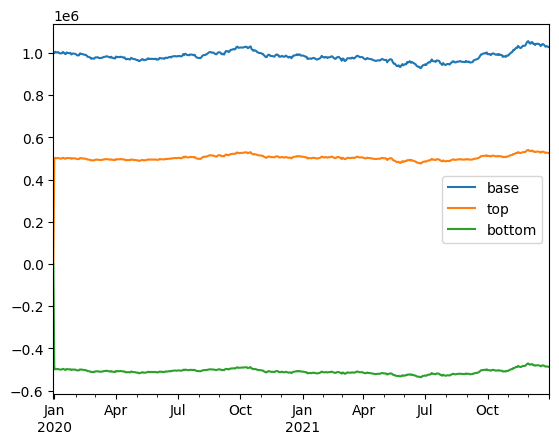

In [ ]:
# Total PNL time series values
pd.DataFrame(
    {
        "base": base_test.strategy.values,
        "top": base_test.strategy["TopStrategy"].values,
        "bottom": base_test.strategy["BottomStrategy"].values,
    }
).plot()

<Axes: >

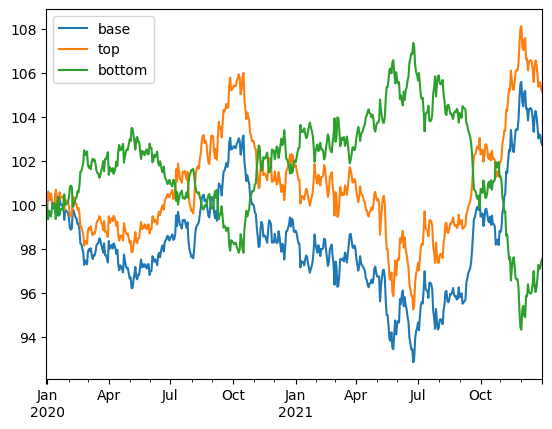

In [ ]:
# "Price" time series values
pd.DataFrame(
    {
        "base": base_test.strategy.prices,
        "top": base_test.strategy["TopStrategy"].prices,
        "bottom": base_test.strategy["BottomStrategy"].prices,
    }
).plot()